### Import Library

In [1]:
from Utils import *
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import statistics as st
import scipy
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.gridspec

# Seed Setting
set_seed()

# Setting Device
device = 1
device = torch.device("cuda:" + str(device) if torch.cuda.is_available() else "cpu")

# Fix Hyperparameters
du1, du2 = 110, 90
top_n = 5
p_val_threshold = 0.05
n_cluster = 3

## Load Best Model & Clustering

### ADNI

In [2]:
# Load Model
data_type = 'ADNI'
dataset = All_Dataset(data_type)
[modality1_values, modality2_values, modality3_values], y = dataset()

adni_net = DMF(modality1_values, modality2_values, modality3_values,
               du1, du2, device).to(device)
adni_net.load_state_dict(torch.load('./Result/Model/Pathway/'+data_type+'/110_90_70_net.pt', map_location=device))
adni_net.eval()

adni_columns = dataset.modality3.columns.to_list()[2:]
adni_label = dataset.modality1.iloc[:, 1].values

# Select Significant Module
sig_module = []
adni_u = adni_net.u.cpu().detach().numpy()
for c in range(adni_u.shape[1]):
    class_0_data = adni_u[adni_label == 0, c]
    class_1_data = adni_u[adni_label == 1, c]
    
    t, p = stats.ttest_ind(class_0_data, class_1_data)
    if p < p_val_threshold:
        sig_module.append(c)

print('Significant Module: {}/{} ({:.2f}%)'.format(len(sig_module), du2, len(sig_module)/du2))
# Check Important Feature
modality_individual = np.abs(torch.tanh(torch.matmul(adni_net.w_modality32, adni_net.w_modality31)).cpu().detach().numpy())
modality_feature_coef = modality_individual[sig_module, :]

modality_selected_feature_index = []
for i in range(len(sig_module)):
    modality_f = modality_feature_coef[i, :]
    modality_selected_feature_index += list(np.argsort(modality_f)[::-1][:top_n])
    
modality_selected_feature_index = list(set(modality_selected_feature_index))
print('Number of Gene: {}'.format(len(np.array(adni_columns)[modality_selected_feature_index])))
print('\nSignificant Gene')
for g in np.array(adni_columns)[modality_selected_feature_index]:
    print(g)

Significant Module: 47/90 (0.52%)
Number of Gene: 220

Significant Gene
FIG4
TBC1D25
 MARCH6
LCP1
SRRM1
SKAP1
CTSL
BCAP31
NPIPA3
TBC1D5
XAF1
RNA18S5
RNA28S5
RNA45S5
MAL
AIMP2
MALAT1
TBCEL
BCL2
CASP4
TBL1XR1
RAB3IP
ZNF438
CNNM3
TRIM6-TRIM34
EIF2D
EIF3A
INPP5D
MANBA
CX3CR1
ARHGEF3
TRIM8
INPP5K
MOB1B
PLD1
DLG3
GTF2IP1
UQCR11
CNPY2
GTF3A
RAB7L1
RNF130
TCEA3
ST13
RNF14
LOC101930172
MAP3K4
FAM192A
CYB5R1
MAPK1
CYBB
ZNF552
YWHAE
CYFIP2
SNORA77
PLOD3
LIMS1
FAM211A-AS1
LIMS2
STARD7
TSG101
LOC441155
SNORD16
STAT4
ARPC2
ZBED1
NCKAP1L
GLTP
FAM217B
HADHA
ALKBH7
COMMD5
AC021078.1
LOC649330
USP7
ASAP2
TSPYL1
RASGEF1B
SNX15
HTATSF1
GNAQ
RASGRP4
NDUFA3
ZC3H11A
SECISBP2
ASH2L
NDUFB7
CGB7
ZCCHC17
PEBP1
DAPP1
MRPS33
ASPHD2
CHCHD2
ZDHHC1
SORL1
STXBP5
ACER3
KPNA2
FTL
FTSJ1
CHD7
ORAI3
PSEN1
JAK1
FUS
NXF1
RPLP1
PSMA4
PSMA5
PSMA6
IER5
SUMO2
PFDN5
ACSL5
THAP11
CHMP5
RPS10
RPS10-NUDT3
PSMB8
ERCC3
OSTF1
LOC100093631
HEXB
SUSD1
SUSD3
RCAN3
TUBB4B
OCIAD2
THOC7
SVILP1
NFIL3
NFKB1
RPS5
IFNGR1
CCNK
ANKS6
ATP5B
DDOST
O

### BRCA

In [3]:
# Load Model
data_type = 'BRCA'
dataset = All_Dataset(data_type)
[modality1_values, modality2_values, modality3_values], y = dataset()

brca_net = DMF(modality1_values, modality2_values, modality3_values,
               du1, du2, device).to(device)
brca_net.load_state_dict(torch.load('./Result/Model/Pathway/'+data_type+'/110_90_70_net.pt', map_location=device))
brca_net.eval()

brca_columns = dataset.modality1.columns.to_list()[2:]
brca_label = dataset.modality1.iloc[:, 1].values

# Select Significant Module
sig_module = []
brca_u = brca_net.u.cpu().detach().numpy()
for c in range(brca_u.shape[1]):
    class_0_data = brca_u[brca_label == 0, c]
    class_1_data = brca_u[brca_label == 1, c]
    class_2_data = brca_u[brca_label == 2, c]
    class_3_data = brca_u[brca_label == 3, c]
    
    F, p = stats.f_oneway(class_0_data, class_1_data, class_2_data, class_3_data)
    if p < 0.05:
        sig_module.append(c)
print('Significant Module: {}/{} ({:.2f}%)'.format(len(sig_module), du2, len(sig_module)/du2))

# Check Important Feature
modality_individual = np.abs(torch.tanh(torch.matmul(brca_net.w_modality12, brca_net.w_modality11)).cpu().detach().numpy())
modality_feature_coef2 = modality_individual[sig_module, :]

modality_selected_feature_index2 = []
for i in range(len(sig_module)):
    modality_f = modality_feature_coef2[i, :]
    modality_selected_feature_index2 += list(np.argsort(modality_f)[::-1][:top_n])
    
modality_selected_feature_index2 = list(set(modality_selected_feature_index2))
print('Number of Gene: {}'.format(len(np.array(brca_columns)[modality_selected_feature_index2])))
for g in np.array(brca_columns)[modality_selected_feature_index2]:
    print(g.split(':')[1])

Significant Module: 76/90 (0.84%)
Number of Gene: 373
SLC25A45
LCAT
SLC35D1
C1orf213
CNOT3
DSN1
HDGF
CYB5R3
ZEB1
KCTD12
OBFC2B
STX16
WTAP
STK25
FLJ10490
DVL2
PRKAA1
YWHAE
ISG20L2
CXorf42
NPAL2
UTP14A
FEM1B
ITGAL
C21orf119
SDC1
BAT3
RAB31
MANSC1
KIAA0256
STT3A
SNTB2
S100A11
GNL2
EVI5
MEPCE
ULBP2
RAP1A
LOC388524
EEF1A1
PRKAB1
BAGE2
INTS3
ALKBH6
INPP5E
COPS7B
ATN1
G3BP1
BAALC
POLK
CDC42EP1
FBXW9
VPS33B
AP2M1
FAM86C
PI4KB
RPS9
LUC7L
TMEM30B
NAT6
LRCH3
EIF1B
SYAP1
LIME1
PGK1
DUSP9
TRIM41
NPDC1
SOS1
PLAU
ITGA1
CUGBP2
TCTN2
CYB5D2
TJP1
SFXN2
SNX10
FRAG1
ARHGEF7
LASS5
LIN54
STK40
RAPGEF4
FLT3LG
IL27RA
ADAT3
GRAMD1A
LUZP1
FAM83H
MCOLN1
ZNF341
METTL7A
ATAD5
NCOA3
C16orf13
TMUB2
BANF1
AGXT2L2
CCDC82
SMAP1L
C11orf57
ZC3H11A
MGC10334
OGT
ITSN2
SENP8
NRAS
TMEM58
SGSM2
TMEM95
GPR172A
PSMD7
CCNT2
ALOX5AP
TEX10
CYP20A1
NARFL
FLJ20254
DMTF1
SIX5
HS1BP3
FRS3
PPIL5
MRPL46
ARAF
PPIL4
ANXA4
ZNF598
CATSPER1
MDN1
CCNG1
hCG_2033311
NUDT14
RPLP1
DENND2D
FAM91A1
PARS2
STK4
FLNB
CCDC123
ATP6V0A2
NUDT16L1
KIAA1109

### Clustering Result

In [4]:
cluster = AgglomerativeClustering(n_clusters=n_cluster, linkage='complete', affinity='correlation').fit(modality_feature_coef[:, modality_selected_feature_index].T)
cluster_pd = pd.DataFrame(columns=['Gene', 'Cluster Label'])
cluster_pd['Gene'] = np.array(adni_columns)[modality_selected_feature_index]
cluster_pd['Cluster Label'] = cluster.labels_

cluster = AgglomerativeClustering(n_clusters=n_cluster, linkage='complete', affinity='correlation').fit(modality_feature_coef2[:, modality_selected_feature_index2].T)
cluster_pd2 = pd.DataFrame(columns=['Gene', 'Cluster Label'])
select_gene_name = lambda x:x.split('gene:')[1]
brca_gene_np = np.array(brca_columns)[modality_selected_feature_index2]
brca_genes = np.array([select_gene_name(xi) for xi in brca_gene_np])
cluster_pd2['Gene'] = brca_genes
cluster_pd2['Cluster Label'] = cluster.labels_

## Visualization

### ADNI

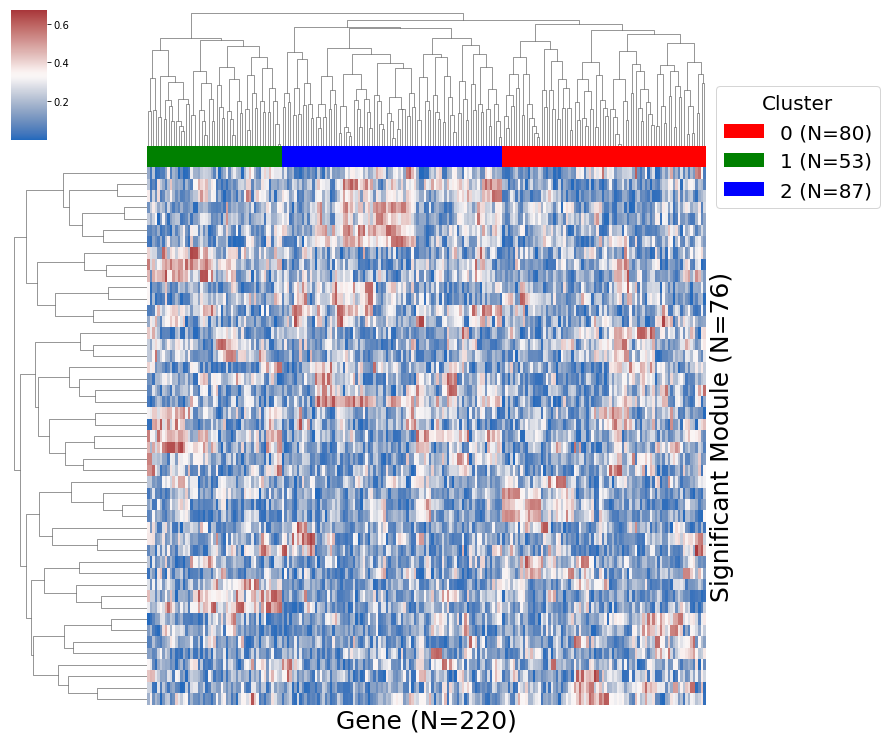

In [5]:
# ADNI Visualization
y_all = cluster_pd['Cluster Label'].values

my_palette =  dict(zip(np.unique(y_all), ['r', 'g', 'b']))
row_colors = pd.DataFrame(y_all)[0].map(my_palette)

g = sns.clustermap(modality_feature_coef[:, modality_selected_feature_index], metric='correlation', cmap = 'vlag',
                   method="complete", col_colors=row_colors.to_numpy(), xticklabels=False, yticklabels=False)

g.ax_heatmap.set_xlabel('Gene (N='+str(len(np.array(adni_columns)[modality_selected_feature_index]))+')', fontsize = 25)
g.ax_heatmap.set_ylabel('Significant Module (N='+str(len(sig_module))+')', fontsize = 25)

label_text = ['0 (N='+str(len(cluster_pd[cluster_pd['Cluster Label'] == 0]))+')', 
              '1 (N='+str(len(cluster_pd[cluster_pd['Cluster Label'] == 1]))+')', 
              '2 (N='+str(len(cluster_pd[cluster_pd['Cluster Label'] == 2]))+')']
for label in [0, 1, 2]:
    g.ax_col_dendrogram.bar(0, 0, color=['r', 'g', 'b'][label],
                            label=label_text[label], linewidth=0)
    
g.ax_col_dendrogram.legend(title='Cluster', loc='upper right', ncol=1, bbox_to_anchor=(1.33, 0.5), 
                           fontsize=20, title_fontsize=20, frameon=True)
plt.show()

### BRCA

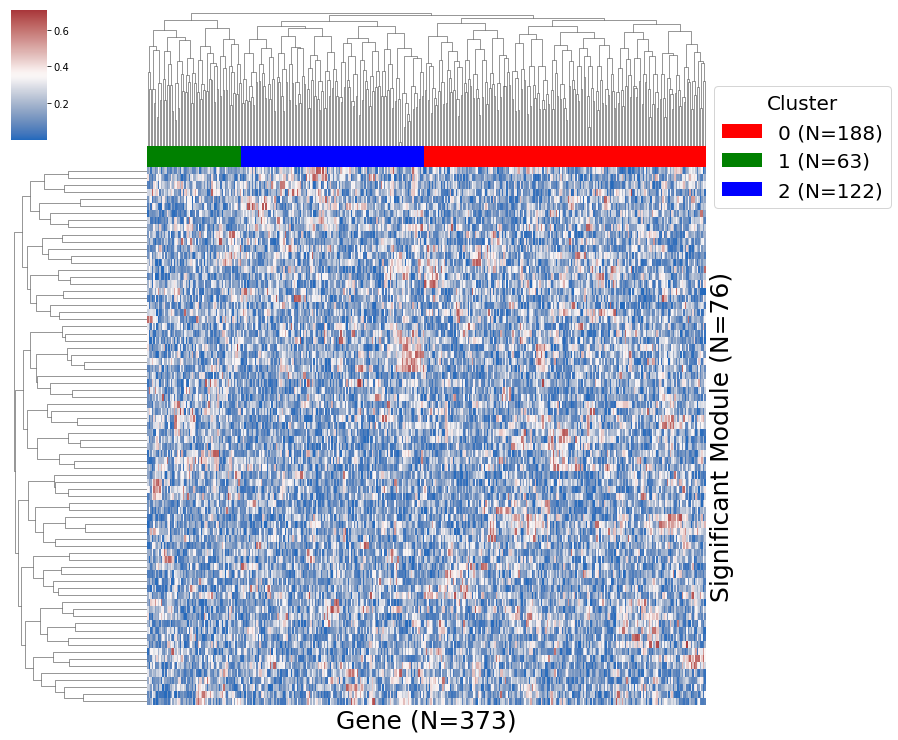

In [6]:
# BRCA Visualization
y_all = cluster_pd2['Cluster Label'].values

my_palette =  dict(zip(np.unique(y_all), ['r', 'g', 'b']))
row_colors = pd.DataFrame(y_all)[0].map(my_palette)

g = sns.clustermap(modality_feature_coef2[:, modality_selected_feature_index2], metric='correlation', cmap = 'vlag',
                   method="complete", col_colors=row_colors.to_numpy(), xticklabels=False, yticklabels=False)

g.ax_heatmap.set_xlabel('Gene (N='+str(len(np.array(adni_columns)[modality_selected_feature_index2]))+')', fontsize = 25)
g.ax_heatmap.set_ylabel('Significant Module (N='+str(len(sig_module))+')', fontsize = 25)

label_text = ['0 (N='+str(len(cluster_pd2[cluster_pd2['Cluster Label'] == 0]))+')', 
              '1 (N='+str(len(cluster_pd2[cluster_pd2['Cluster Label'] == 1]))+')', 
              '2 (N='+str(len(cluster_pd2[cluster_pd2['Cluster Label'] == 2]))+')']
for label in [0, 1, 2]:
    g.ax_col_dendrogram.bar(0, 0, color=['r', 'g', 'b'][label],
                            label=label_text[label], linewidth=0)
    
g.ax_col_dendrogram.legend(title='Cluster', loc='upper right', ncol=1, bbox_to_anchor=(1.35, 0.5), 
                           fontsize=20, title_fontsize=20, frameon=True)

plt.show()

## Cluster Genes

### ADNI
**Cluster 0**

In [7]:
print('Number of Gene: {}'.format(len(cluster_pd[cluster_pd['Cluster Label'] == 0])))
for g in cluster_pd[cluster_pd['Cluster Label'] == 0]['Gene'].to_list():
    print(g)

Number of Gene: 80
TBC1D25
SRRM1
TBC1D5
XAF1
AIMP2
MALAT1
BCL2
CNNM3
EIF3A
INPP5D
CX3CR1
ARHGEF3
TRIM8
INPP5K
LOC101930172
YWHAE
SNORA77
PLOD3
LIMS2
STARD7
LOC441155
ARPC2
ZBED1
FAM217B
HADHA
AC021078.1
USP7
NDUFA3
ZC3H11A
ASH2L
CGB7
ZDHHC1
SORL1
CHD7
JAK1
FUS
PSMA4
PSMA5
PSMA6
CHMP5
TUBB4B
THOC7
NFKB1
ATP5B
DDOST
OGT
SYNE2
TOPORS
C9ORF169
OPA3
SPCS1
PHLPP1
DDX60
UBALD1
CD4
LOC100653071
PPP1R14B
TRAF3IP2
MYC
GATAD2A
B2M
UBL7
TMED10
TMEM101
AFF1
RHOBTB2
DGKA
PPP6R1
LBH
CTCF
HNRNPA1P10
ARAP2
TRIM22
ARF1
SAMD9
PKM
AGPAT2
CAPNS1
MLLT1
MYSM1


**Cluster 1**

In [8]:
print('Number of Gene: {}'.format(len(cluster_pd[cluster_pd['Cluster Label'] == 1])))
for g in cluster_pd[cluster_pd['Cluster Label'] == 1]['Gene'].to_list():
    print(g)

Number of Gene: 53
FIG4
BCAP31
RNA18S5
RNA28S5
RNA45S5
TBCEL
TBL1XR1
ZNF438
TRIM6-TRIM34
MANBA
MOB1B
PLD1
UQCR11
RAB7L1
ST13
RNF14
FAM192A
LIMS1
FAM211A-AS1
NCKAP1L
ALKBH7
LOC649330
ASAP2
TSPYL1
SNX15
NDUFB7
ZCCHC17
CHCHD2
KPNA2
NXF1
RPLP1
IER5
PFDN5
RPS10
RPS10-NUDT3
PSMB8
ERCC3
SUSD1
RPS5
CCNK
ATP6V0E1
U2AF1
C9ORF91
HIST1H4C
PPP1CA
TPT1
SPINT2
DENND4B
LOC101060301
PPP3R1
WIBG
SQRDL
TRIM14


**Cluster 2**

In [9]:
print('Number of Gene: {}'.format(len(cluster_pd[cluster_pd['Cluster Label'] == 2])))
for g in cluster_pd[cluster_pd['Cluster Label'] == 2]['Gene'].to_list():
    print(g)

Number of Gene: 87
 MARCH6
LCP1
SKAP1
CTSL
NPIPA3
MAL
CASP4
RAB3IP
EIF2D
DLG3
GTF2IP1
CNPY2
GTF3A
RNF130
TCEA3
MAP3K4
CYB5R1
MAPK1
CYBB
ZNF552
CYFIP2
TSG101
SNORD16
STAT4
GLTP
COMMD5
RASGEF1B
HTATSF1
GNAQ
RASGRP4
SECISBP2
PEBP1
DAPP1
MRPS33
ASPHD2
STXBP5
ACER3
FTL
FTSJ1
ORAI3
PSEN1
SUMO2
ACSL5
THAP11
OSTF1
LOC100093631
HEXB
SUSD3
RCAN3
OCIAD2
SVILP1
NFIL3
IFNGR1
ANKS6
PHC1
RRAGD
NHP2L1
CCT4
FBXO38
TLE4
UBAP1
TACC1
UBE2E2
RGCC
NLRC3
ZNF217
HK2
TMBIM1
APLP2
LY9
UBE4A
GPX4
DENND2D
PILRA
TAOK3
PINK1
LAT
PYGO2
LATS2
GDE1
IL2RA
CLPTM1L
LOC101060794
C19ORF12
ZNF337
TRIM25
BAZ1B


### BRCA
**Cluster 0**

In [10]:
print('Number of Gene: {}'.format(len(cluster_pd2[cluster_pd2['Cluster Label'] == 0])))
for g in cluster_pd2[cluster_pd2['Cluster Label'] == 0]['Gene'].to_list():
    print(g)

Number of Gene: 188
SLC25A45
LCAT
HDGF
CYB5R3
ZEB1
STX16
STK25
PRKAA1
ISG20L2
CXorf42
UTP14A
FEM1B
ITGAL
SDC1
BAT3
STT3A
S100A11
EVI5
ULBP2
LOC388524
EEF1A1
PRKAB1
INPP5E
COPS7B
G3BP1
POLK
CDC42EP1
VPS33B
AP2M1
PI4KB
LUC7L
TMEM30B
LRCH3
EIF1B
PGK1
SOS1
ITGA1
TCTN2
CYB5D2
LASS5
STK40
FLT3LG
IL27RA
GRAMD1A
LUZP1
MCOLN1
ZNF341
METTL7A
NCOA3
TMUB2
BANF1
AGXT2L2
C11orf57
MGC10334
TMEM58
SGSM2
NARFL
FLJ20254
HS1BP3
FRS3
ARAF
ANXA4
ZNF598
MDN1
CCNG1
hCG_2033311
DENND2D
FLNB
CCDC123
ATP6V0A2
KIAA1109
KIAA1618
TMSB10
ZEB2
TCF4
JOSD1
ZCCHC8
MTPN
DYRK3
FHOD1
PALM
NDFIP1
FLJ10154
TP53I13
MAPK1
HN1L
PUM1
CBR3
SRM
PSMG3
C14orf49
SART1
MAGI2
ACTB
ZNF484
NFKBIE
MBOAT5
AVEN
MLZE
CLPTM1L
BAP1
YKT6
SKP1A
TNFSF12
EXT1
ZC3H6
PDCL
SCAMP2
C8orf53
CLK2
EPS15
MAGOH
GDI1
CCNF
RUNX1T1
GATAD2B
UNC84B
STRN
L3MBTL
UTRN
VARS
NRF1
PHF19
MYBBP1A
RP11-78J21.1
MAPKAP1
INPP1
TAGLN3
C3orf52
TTYH3
POLDIP3
CLIP2
NCSTN
SMARCC1
C1orf124
NR2F6
PTGES2
C1orf19
SCN4B
PIK3R2
FAS
PTK7
COMMD2
NDUFA1
TNFRSF14
YPEL3
ALDH1B1
PARP6
PSMD

**Cluster 1**

In [11]:
print('Number of Gene: {}'.format(len(cluster_pd2[cluster_pd2['Cluster Label'] == 1])))
for g in cluster_pd2[cluster_pd2['Cluster Label'] == 1]['Gene'].to_list():
    print(g)

Number of Gene: 63
CNOT3
KCTD12
WTAP
NPAL2
C21orf119
KIAA0256
MEPCE
RAP1A
BAGE2
FBXW9
FAM86C
NAT6
TRIM41
CUGBP2
SFXN2
FRAG1
LIN54
FAM83H
CCDC82
SMAP1L
ZC3H11A
TMEM95
GPR172A
ALOX5AP
PPIL5
MRPL46
PPIL4
NUDT14
FAM91A1
BRMS1L
CPNE8
CENTD2
GRINA
C14orf132
PRR12
MAP4
ARL6IP1
ITGB1
IMPDH2
CSNK1E
ZNF358
TARS2
NDUFC1
MGC29891
HCFC1R1
HCFC2
PTK2B
TMEM40
MOBKL1B
MRPS18C
PDE8A
RHPN1
LY86
C8orf30A
HNRPM
ANKRD54
ZBTB7A
GLMN
SCAF1
CACNG1
RNF138
LARGE
GNB2L1


**Cluster 2**

In [12]:
print('Number of Gene: {}'.format(len(cluster_pd2[cluster_pd2['Cluster Label'] == 2])))
for g in cluster_pd2[cluster_pd2['Cluster Label'] == 2]['Gene'].to_list():
    print(g)

Number of Gene: 122
SLC35D1
C1orf213
DSN1
OBFC2B
FLJ10490
DVL2
YWHAE
RAB31
MANSC1
SNTB2
GNL2
INTS3
ALKBH6
ATN1
BAALC
RPS9
SYAP1
LIME1
DUSP9
NPDC1
PLAU
TJP1
SNX10
ARHGEF7
RAPGEF4
ADAT3
ATAD5
C16orf13
OGT
ITSN2
SENP8
NRAS
PSMD7
CCNT2
TEX10
CYP20A1
DMTF1
SIX5
CATSPER1
RPLP1
PARS2
STK4
NUDT16L1
TRPC1
REEP6
FBXL5
GTF2H3
FAM126B
NUP62
SEPN1
SLAMF9
SPPL2A
BGN
ZNF610
SACM1L
C7orf10
THY1
HSD17B10
TMCO6
ERCC6
SFRS1
UGT8
HSPG2
CREB3L4
CPOX
ABCC11
AGTRAP
SHKBP1
ANKRD32
DGKA
DIXDC1
IARS2
ZNF254
DMXL2
MYL9
CDC23
HSD17B6
RANBP9
NDUFAB1
TSTA3
EHMT1
PPM1M
GNAI2
ERCC2
TIMELESS
PIK3IP1
LDHA
PASK
HESX1
ADAMTSL2
KIAA1279
YAF2
HNRNPA2B1
RRP9
ILDR1
M-RIP
XRN1
GOLGA8A
UCP2
SFRS2
YBX1
RNASEN
SCARF2
SLC35E4
SPRED2
PLA2G12A
ANKRD9
ZNF766
LGALS1
C12orf24
ARL6
HHLA3
SRRM2
STAM2
CEP110
SPCS1
C2orf55
HCN3
CBX7
CHSY-2
PAFAH1B1
SCARB2


## Enrichr Result

### ADNI

In [13]:
cluster_0 = pd.read_csv('./Result/Pathway/ADNI_Cluster_0.txt', sep='\t')
cluster_0.insert(loc=0, column='Cluster', value=[0]*len(cluster_0))

cluster_1 = pd.read_csv('./Result/Pathway/ADNI_Cluster_1.txt', sep='\t')
cluster_1.insert(loc=0, column='Cluster', value=[1]*len(cluster_1))

cluster_2 = pd.read_csv('./Result/Pathway/ADNI_Cluster_2.txt', sep='\t')
cluster_2.insert(loc=0, column='Cluster', value=[2]*len(cluster_2))

adni_cluster_pd = pd.concat([cluster_0, cluster_1, cluster_2])
adni_cluster_pd = adni_cluster_pd[['Cluster', 'Term', 'Overlap', 'P-value', 'Adjusted P-value', 'Genes']]

# Filtering by Adjusted P-value
adni_cluster_pd = adni_cluster_pd[adni_cluster_pd['Adjusted P-value'] < 0.05]
adni_cluster_pd.reset_index(drop=True, inplace=True)

# Change Overlap
adni_cluster_pd['Overlap'] = adni_cluster_pd['Overlap'].apply(lambda x:int(x.split('/')[0]))

# Change Genes
adni_cluster_pd['Genes'] = adni_cluster_pd['Genes'].apply(lambda x:x.replace(';',', '))

# Change P-value & Adjusted P-value
adni_cluster_pd['P-value'] = adni_cluster_pd['P-value'].apply(lambda x:to_precision(x,2))
adni_cluster_pd['Adjusted P-value'] = adni_cluster_pd['Adjusted P-value'].apply(lambda x:to_precision(x,2))

adni_cluster_pd

,Cluster,Term,Overlap,P-value,Adjusted P-value,Genes
0,0,Epstein-Barr virus infection,6,1.6E-4,0.025,"USP7, MYC, BCL2, B2M, NFKB1, JAK1"
1,0,Salmonella infection,6,4.9E-4,0.025,"ARF1, ARPC2, MYC, BCL2, TUBB4B, NFKB1"
2,0,Pathways of neurodegeneration,8,6.2E-4,0.025,"PSMA5, PSMA6, PSMA4, FUS, NDUFA3, BCL2, TUBB4B..."
3,0,Amyotrophic lateral sclerosis,7,6.3E-4,0.025,"PSMA5, PSMA6, PSMA4, FUS, NDUFA3, BCL2, TUBB4B"
4,0,Proteasome,3,8.3E-4,0.026,"PSMA5, PSMA6, PSMA4"
5,0,Transcriptional misregulation in cancer,5,1.0E-3,0.026,"FUS, MYC, MLLT1, AFF1, NFKB1"
6,0,Pathogenic Escherichia coli infection,5,1.2E-3,0.026,"ARF1, TMED10, ARPC2, TUBB4B, NFKB1"
7,0,Viral carcinogenesis,5,1.3E-3,0.026,"YWHAE, USP7, PKM, NFKB1, JAK1"
8,0,Human T-cell leukemia virus 1 infection,5,1.9E-3,0.032,"CD4, MYC, B2M, NFKB1, JAK1"
9,0,PI3K-Akt signaling pathway,6,2.9E-3,0.040,"YWHAE, PHLPP1, MYC, BCL2, NFKB1, JAK1"


### BRCA

In [14]:
cluster_0 = pd.read_csv('./Result/Pathway/BRCA_Cluster_0.txt', sep='\t')
cluster_0.insert(loc=0, column='Cluster', value=[0]*len(cluster_0))

cluster_1 = pd.read_csv('./Result/Pathway/BRCA_Cluster_1.txt', sep='\t')
cluster_1.insert(loc=0, column='Cluster', value=[1]*len(cluster_1))

cluster_2 = pd.read_csv('./Result/Pathway/BRCA_Cluster_2.txt', sep='\t')
cluster_2.insert(loc=0, column='Cluster', value=[2]*len(cluster_2))

BRCA_cluster_pd = pd.concat([cluster_0, cluster_1, cluster_2])
BRCA_cluster_pd = BRCA_cluster_pd[['Cluster', 'Term', 'Overlap', 'P-value', 'Adjusted P-value', 'Genes']]

# Filtering by Adjusted P-value
BRCA_cluster_pd = BRCA_cluster_pd[BRCA_cluster_pd['Adjusted P-value'] < 0.05]
BRCA_cluster_pd.reset_index(drop=True, inplace=True)

# Change Overlap
BRCA_cluster_pd['Overlap'] = BRCA_cluster_pd['Overlap'].apply(lambda x:int(x.split('/')[0]))

# Change Genes
BRCA_cluster_pd['Genes'] = BRCA_cluster_pd['Genes'].apply(lambda x:x.replace(';',', '))

# Change P-value & Adjusted P-value
BRCA_cluster_pd['P-value'] = BRCA_cluster_pd['P-value'].apply(lambda x:to_precision(x,2))
BRCA_cluster_pd['Adjusted P-value'] = BRCA_cluster_pd['Adjusted P-value'].apply(lambda x:to_precision(x,2))

BRCA_cluster_pd

,Cluster,Term,Overlap,P-value,Adjusted P-value,Genes
0,0,Hepatocellular carcinoma,8,1.9E-4,0.017,"SMARCC1, CSNK1A1, ARAF, MAPK1, PIK3R2, POLK, S..."
1,0,Endometrial cancer,5,2.1E-4,0.017,"ARAF, MAPK1, PIK3R2, POLK, SOS1"
2,0,Natural killer cell mediated cytotoxicity,7,2.4E-4,0.017,"ARAF, MAPK1, FAS, PIK3R2, ULBP2, ITGAL, SOS1"
3,0,Acute myeloid leukemia,5,4.2E-4,0.018,"ARAF, MAPK1, PIK3R2, SOS1, RUNX1T1"
4,0,Breast cancer,7,4.9E-4,0.018,"CSNK1A1, NCOA3, ARAF, MAPK1, PIK3R2, POLK, SOS1"
5,0,Non-small cell lung cancer,5,5.8E-4,0.018,"ARAF, MAPK1, PIK3R2, POLK, SOS1"
6,0,Glioma,5,7.1E-4,0.018,"ARAF, MAPK1, PIK3R2, POLK, SOS1"
7,0,Proteoglycans in cancer,8,7.3E-4,0.018,"ARAF, SDC1, MAPK1, FAS, PIK3R2, FLNB, SOS1, ACTB"
8,0,Chronic myeloid leukemia,5,7.5E-4,0.018,"ARAF, MAPK1, PIK3R2, POLK, SOS1"
9,0,Colorectal cancer,5,1.3E-3,0.028,"ARAF, MAPK1, PIK3R2, POLK, SOS1"
